In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7001


In [46]:
# %tb

import importlib
import traj_optim
import fsm_utils

importlib.reload(traj_optim)
importlib.reload(fsm_utils)
from traj_optim import TrajectoryOptimizationSolution, read_csv
from fsm_utils import (
    LEFT_STANCE, RIGHT_STANCE, SPACE_STANCE, DOUBLE_SUPPORT
)

# Walking

# Blue is Right feet, Red is left

solver = TrajectoryOptimizationSolution()
N = 8
mode_seqs = [RIGHT_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 1
initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
tf = 0.2 # just now is tf = 2
destination = 0.3

x_traj, u_traj, prog = solver.solve(N, 
                                    mode_seqs, 
                                    repeat, 
                                    initial_states,
                                     mu=0.5, 
                                     tf=tf, 
                                     destination=destination, 
                                     iters=2e4,
                                     test=True)

Whole x shape:  (1, 8, 14)
Testing Mode, Keep the biped standing. Swing left legs backwards
mu = 0.5
Testing  20000.0  iterations
Time taken: 11.100839457998518 seconds
Check whether the friction cone constraint holds?
optimal cost:  0.0
x_sol:  [[[ 4.89526693e-14  8.00000000e-01  9.40315925e-15 -6.43501110e-01
    1.28700222e+00 -6.43501110e-01  1.28700222e+00 -1.73362748e-13
    1.24062185e-13  1.05735835e-13  5.06258141e-14  1.92434292e-13
    3.93051698e-14  0.00000000e+00]
  [ 5.08147157e-02  8.01204714e-01  1.99040442e-02 -8.79792432e-01
    5.74484993e-01 -7.26415191e-01  1.26551891e+00 -3.26605437e-01
   -6.31855004e-02 -1.28972865e+00 -1.35992013e+01 -1.50000000e+01
   -1.74459097e+00  8.71496788e-02]
  [-2.11860116e-01  7.45629122e-01 -2.07132931e-01 -1.21842043e+00
    6.93555169e-01 -5.66073423e-01  1.34138743e+00 -1.06941210e-01
    1.12700794e-01 -6.47989885e-01  1.52241172e+00 -1.50000000e+01
   -7.02235520e-01 -2.39623207e-01]
  [ 1.35850577e-01  7.86105096e-01  6.62894

In [37]:
solver = TrajectoryOptimizationSolution()
N = 4
mode_seqs = [RIGHT_STANCE, LEFT_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 2
initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
tf = 0.8 # just now is tf = 2
destination = 0.3

x_traj, u_traj, prog = solver.solve(N, 
                                    mode_seqs, 
                                    repeat, 
                                    initial_states,
                                     mu=0.5, 
                                     tf=tf, 
                                     destination=destination, 
                                     iters=2e4,
                                     test=False)

Whole x shape:  (4, 4, 14)
Destination: 0.3m
mu = 0.5
Testing destination cost
Testing  20000.0  iterations
Time taken: 103.66777604201343 seconds
Check whether the friction cone constraint holds?
Friction Cone Constraint Not Hold
lambda_c_m1_1: [-560.70375914    0.         1121.40751829]
optimal cost:  2380.910810714771
x_sol:  [[[-2.28487590e-13  8.00000000e-01 -7.65063366e-14 -6.43501110e-01
    1.28700222e+00 -6.43501110e-01  1.28700222e+00 -7.05383268e-14
   -2.71420923e-13  2.75916069e-13  7.13793751e-14  1.04858675e-13
    4.28076814e-14 -2.41725564e-13]
  [ 1.79557484e-01  7.79286718e-01  1.66992982e-01 -3.78808231e-01
    1.73581037e+00 -7.52190206e-01  1.22993608e+00  2.49658257e-01
   -1.88654597e-01  1.08089940e+00  1.06367515e+01  1.12080109e+01
    8.61731441e-01  8.83208357e-01]
  [-3.98217505e-01  6.00000000e-01 -2.08579514e-01  2.66692617e-01
    1.79095070e+00 -2.48676305e-01  1.40871479e+00  2.56599831e-01
   -4.65011581e-01  9.44845299e-01  9.44299478e+00 -1.5000000

## Visualization

RuntimeError: You've tried evaluating time derivatives or their residuals.

The provided context doesn't show a connection for the plant's query input port (see MultibodyPlant::get_geometry_query_input_port()). See https://drake.mit.edu/troubleshooting.html#mbp-unconnected-query-object-port for help.

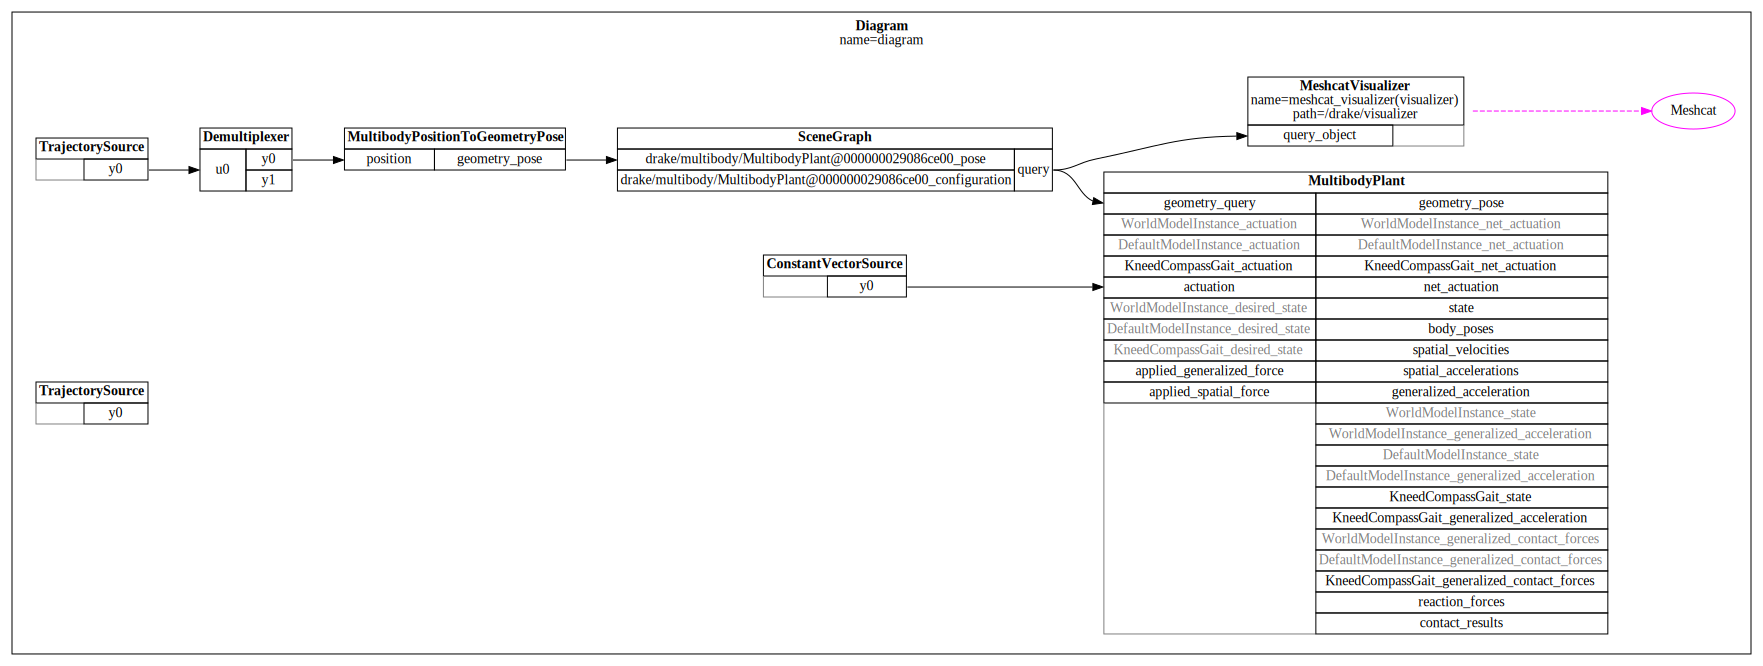

In [42]:
%tb
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
import pydot
from IPython.display import SVG, display


from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction
)



# Create a MultibodyPlant for the arm
file_name = "planar_walker.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
plant = builder.AddSystem(MultibodyPlant(0.0))
#plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.05)
plant.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=plant).AddModels(file_name)

plant.WeldFrames(
            plant.world_frame(),
            plant.GetBodyByName("base").body_frame(),
            RigidTransform.Identity()
        )

plant.Finalize()
"""

builder = DiagramBuilder()

# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.05)
#plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 10)

X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", 
    CoulombFriction(1.0, 1.0)
)
parser = Parser(plant)
parser.AddModels("planar_walker.urdf")
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()
"""


n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()

x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), plant.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))
builder.Connect(scene_graph.get_query_output_port(), plant.get_geometry_query_input_port())


MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")

display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


# Visualize the motion for `n_playback` times
# n_playback = 3
# for i in range(n_playback):
#   # Set up a simulator to run this diagram.
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(0.05)
simulator.AdvanceTo(tf);
time.sleep(2)